<a href="https://colab.research.google.com/github/Roywangxixixixixia/ArtificialInTech/blob/main/Deep_Learning_Reproducibility_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithm steps

# Step 1: Load the dataset
    dataset = load_dataset()

# Step 2: Split the dataset into training and testing sets
    train_data, test_data = split_dataset(dataset)

# Step 3: Preprocess the data
    train_data_processed = preprocess_data(train_data)
    test_data_processed = preprocess_data(test_data)

# Step 4: Train the model
    model = train_model(train_data_processed)

# Step 5: Evaluate the model on the test set
    test_accuracy = evaluate_model(model, test_data_processed)

# Step 6: Calculate the neuron activations for each sample in the test set
    def calculate_activations(model, test_data_processed):
        neuron_activations = []
        for sample in test_data_processed:
            activations = model.forward(sample)
            neuron_activations.append(activations)
        return neuron_activations

# Step 7: Compute the exclusivity scores for each neuron
    def calculate_exclusivity_scores(neuron_activations):
        num_samples = len(neuron_activations)
        num_neurons = neuron_activations[0].shape[0]
        neuron_exclusivity_scores = np.zeros(num_neurons)
        for neuron_idx in range(num_neurons):
            activations = np.zeros(num_samples)
            for sample_idx in range(num_samples):
                activations[sample_idx] = neuron_activations[sample_idx][neuron_idx]
            exclusivity_score = calculate_exclusivity_score(activations)
            neuron_exclusivity_scores[neuron_idx] = exclusivity_score
        return neuron_exclusivity_scores

    def calculate_exclusivity_score(activations):
        activation_freq = np.bincount(activations)
        num_unique_activations = np.count_nonzero(activation_freq)
        if num_unique_activations == 1:
            exclusivity_score = 0
        else:
            max_activation_freq = np.max(activation_freq)
            exclusivity_score = 1 - (max_activation_freq / len(activations))
        return exclusivity_score

# Step 8: Select the most exclusive neurons
    def select_neurons(neuron_exclusivity_scores, num_neurons_to_select):
        sorted_indices = np.argsort(neuron_exclusivity_scores)
        selected_neurons = sorted_indices[:num_neurons_to_select]
        return selected_neurons

# Step 9: Use the selected neurons to reconstruct the input data
    def reconstruct_data(model, test_data_processed, selected_neurons):
        reconstructed_data = []
        for sample in test_data_processed:
            activations = model.forward(sample)
            reconstructed_activations = np.zeros_like(activations)
            reconstructed_activations[selected_neurons] = activations[selected_neurons]
            reconstructed_sample = model.backward(reconstructed_activations)
            reconstructed_data.append(reconstructed_sample)
        return reconstructed_data

# Step 10: Evaluate the quality of the reconstructed data
    def evaluate_reconstruction(reconstructed_data, test_data_processed):
        reconstruction_errors = []
        for i in range(len(reconstructed_data)):
            reconstruction_error = calculate_reconstruction_error(reconstructed_data[i], test_data_processed[i])
            reconstruction_errors.append(reconstruction_error)
        return np.array(reconstruction_errors)

    def calculate_reconstruction_error(reconstructed_sample, original_sample):
        return np.linalg.norm(reconstructed_sample - original_sample)

# Step 11: Analyze the security boundary of the reconstruction by comparing the reconstruction quality with the number of selected neurons
    def analyze_security_boundary(reconstruction_quality, selected_neurons):
        sorted_indices = np.argsort(selected_neurons)
        sorted_quality = reconstruction_quality[sorted_indices]
        num_neurons = len(selected_neurons)
        num_samples = len(reconstruction_quality)
        security_boundary = np.zeros(num_neurons)
        for i in range(num_neurons):
            threshold = sorted_quality[int(num_samples*(i+1)/num_neurons)-1]
            security_boundary[i] = threshold
        return security_boundary

# Step 12: Visualize the results
    def visualize_results(reconstruction_quality, selected_neurons, security_boundary):
        # Plot the reconstruction quality as a function of the number of selected neurons
        plt.plot(range(len(selected_neurons)), reconstruction_quality, label="Reconstruction Quality")
        # Plot the security



# Imports

In [21]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim


# Steps 1 - 3

In [88]:
image_size = 8
DATA_DIR = 'content/retinamnist.npz'
data = np.load('/content/retinamnist.npz')
X_train = data['train_images']
X_train_label = torch.from_numpy(data['train_labels']).reshape(1080)
print(f"Shape of training data: {X_train.shape}")
print(f"Shape of training data: {X_train_label.shape}")
print(f"Data type: {type(X_train)}")
print(f"Data type: {type(X_train_label)}")
print(X_train_label)

Shape of training data: (1080, 28, 28, 3)
Shape of training data: torch.Size([1080])
Data type: <class 'numpy.ndarray'>
Data type: <class 'torch.Tensor'>
tensor([0, 0, 0,  ..., 2, 2, 3], dtype=torch.uint8)


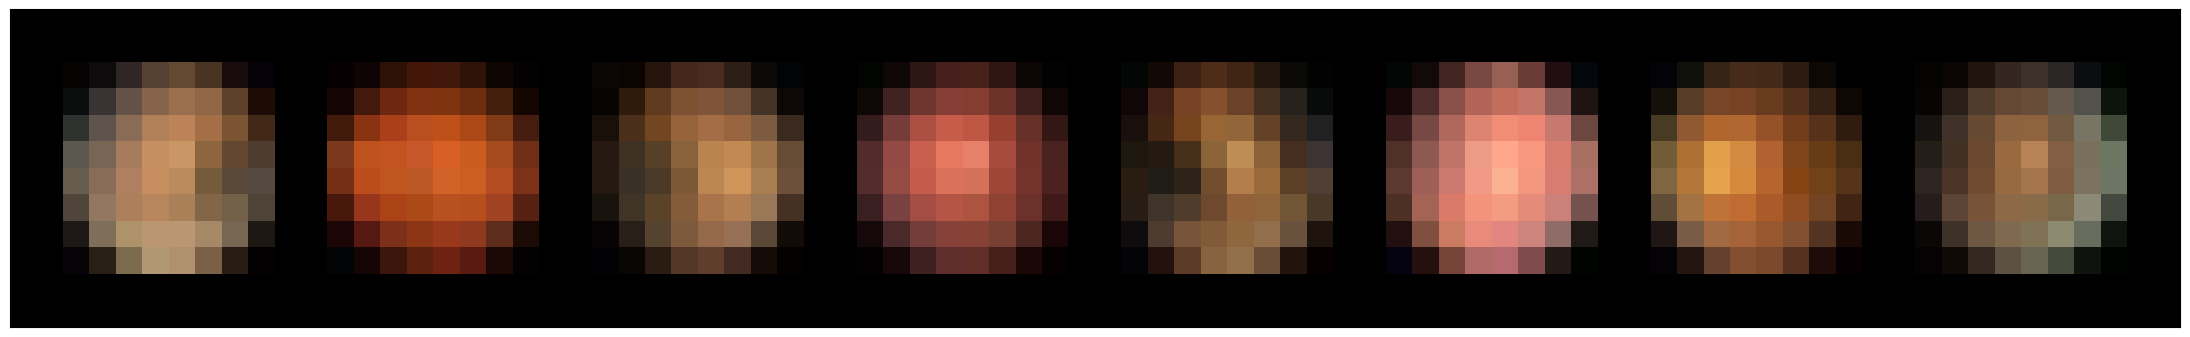

In [100]:
transform = T.Compose([
                        T.ToPILImage(),
                        T.Resize(image_size),
                        #T.RandomResizedCrop(image_size),
                        T.ToTensor()])

class croppedDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, ims):
        'Initialization'
        self.ims = ims
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ims)
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.ims[index]
        X = transform(image)
        return X
        
def show_images(images, nmax=8):
    fig, ax = plt.subplots(figsize=(28, 28))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=8):
    for images in dl:
        show_images(images, nmax)
        break

batch_size = 8
cropped_train_dataset = croppedDataset(ims=X_train)


# train_dl_s = X_train
# train_dl_label_s = X_train_label

# for i in range(0,len(X_train)):
#   train_dl_s[i] = transform(X_train[i]) 
#   train_dl_label_s[i] = transform(X_train_label[i])

train_dl = DataLoader(cropped_train_dataset, batch_size, shuffle=True)
train_dl_label = DataLoader(X_train_label, batch_size, shuffle=True)

show_batch(train_dl)

# Step 4

In [99]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(8, 512)
      self.fc2 = nn.Linear(512, 32)
      self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
      x = self.fc1(x)
      # Use the rectified-linear activation function over x
      x = F.relu(x)

      x = self.fc2(x)
      # Use the rectified-linear activation function over x
      x = F.relu(x)

      x = self.fc3(x)

      # Apply softmax to x
      output = F.log_softmax(x, dim=1)
      return output
    
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
for epoch in range(10):
    running_loss = 0.0
for i, data in enumerate(train_dl, 0):
    inputs = data
for i, data in enumerate(train_dl_label, 0):
    labels = data
    
# Zero the parameter gradients
optimizer.zero_grad()

# Forward + backward + optimize
outputs = net(inputs)
print(outputs)
print(labels)
print(f"Shape of training data: {outputs.shape}")
print(f"Shape of training data: {labels.shape}")
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()

# Print statistics
running_loss += loss.item()
if i % 100 == 99:  # Print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
           (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

tensor([[[[-1.0976],
          [-1.1031],
          [-1.1105],
          [-1.1168],
          [-1.1181],
          [-1.1143],
          [-1.1058],
          [-1.0977]],

         [[-1.0996],
          [-1.0976],
          [-1.0963],
          [-1.0947],
          [-1.0940],
          [-1.0944],
          [-1.0968],
          [-1.0992]],

         [[-1.0987],
          [-1.0951],
          [-1.0892],
          [-1.0847],
          [-1.0841],
          [-1.0873],
          [-1.0932],
          [-1.0989]]],


        [[[-1.0994],
          [-1.0989],
          [-1.1007],
          [-1.1035],
          [-1.1036],
          [-1.1015],
          [-1.0991],
          [-1.0983]],

         [[-1.0991],
          [-1.0990],
          [-1.0984],
          [-1.0983],
          [-1.0982],
          [-1.0979],
          [-1.0987],
          [-1.0990]],

         [[-1.0973],
          [-1.0979],
          [-1.0967],
          [-1.0940],
          [-1.0940],
          [-1.0964],
          [-1.0981],
 

RuntimeError: ignored